/liuzicheng/anaconda3/envs/evo-design/lib/python3.11/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


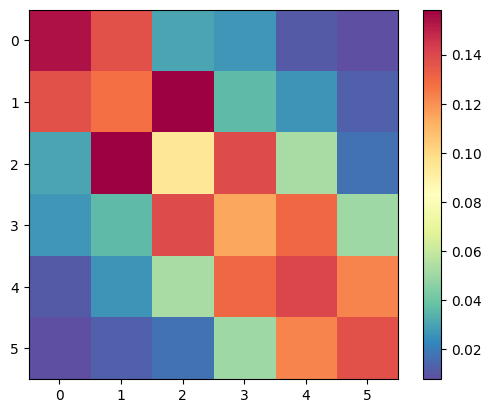

In [1]:
orca_path='/genomic_structure/train/log/orca/weight/model_orcah1esc_a_orca20240512_104757.checkpoint'
hyena_path='/genomic_structure/train/log/hyena/weight/model_hyenah1esc_a20240515_065813.checkpoint'
mamba_path='/genomic_structure/train/log/mamba/weight/model_mambah1esc_a20240512_150132.checkpoint'
import sys
sys.path.append('/src/dataloaders')
from selene_utils2 import *
from matplotlib import pyplot as plt
batch_size=5
max_length=6000
dest_path='/genomic_structure/resources/resources'
t = Genomic2DFeatures(
            [dest_path + "/4DNFI9GMP2J8.rebinned.mcool::/resolutions/1000"],
            ["r1000"],
            (int(max_length/1000), int(max_length/1000)),
            cg=True,
        )

sampler = RandomPositionsSamplerHiC(
            reference_sequence=MemmapGenome(
                input_path=dest_path + "/Homo_sapiens.GRCh38.dna.primary_assembly.fa",
                memmapfile=dest_path + "/Homo_sapiens.GRCh38.dna.primary_assembly.fa.mmap",
                blacklist_regions="hg38",
            ),
            target=t,
            # target_1d=MultibinGenomicFeatures(
            #     self.dest_path + "/h1esc/h1esc.hg38.bed.sorted.gz",
            #     np.loadtxt(self.dest_path + "/h1esc/h1esc.hg38.bed.sorted.features", str),
            #     1000,
            #     1000,
            #     (32, 10),
            #     mode="any",
            # ),
            features=["r1000"],
            test_holdout=["chr9", "chr10"],
            validation_holdout=["chr8"],
            sequence_length=6000,
            position_resolution=1000,
            random_shift=100,
            random_strand=False,
            cross_chromosome=False,
        )
sampler.mode = "validate"
for i in range(10):
    sampled_data = sampler.sample(batch_size=batch_size)

    while np.isnan(sampled_data[1]).any():
                sampled_data = sampler.sample(batch_size=batch_size)

# print(sampled_data)
plt.imshow(sampled_data[1][0, :, :],cmap = 'Spectral_r')   
plt.colorbar()


In [2]:
sequence=sampled_data[0]
target=sampled_data[1]
target=torch.from_numpy(target).float().cuda()
sequence_b=np.zeros((sequence.shape[0],sequence.shape[1]))
mask=np.where(sequence==0.25)
sequence_b=sequence.argmax(axis=2)
sequence_b[[mask[0],mask[1]]]=4
sequence=sequence_b
map_to_genomic_sequence = {0: 'A', 1: 'C', 2: 'G', 3: 'T', 4: 'N'}
#map sequence to genome 
sequence = "".join(map(lambda x: map_to_genomic_sequence[x], sequence.flatten().tolist()))
#reshape list
# sequence = np.array(list(sequence)).reshape(batch_size,-1)
from scipy.stats import pearsonr
def genomic_structure_corr(logit,y,ignore_index=-100):


    pred=logit
    target=y
    normmat_bydist = np.exp(
        np.load("/orca/resources/resources/4DNFI9GMP2J8.rebinned.mcool.expected.res1000.npy")        

    )[:10]
    normmat = normmat_bydist[np.abs(np.arange(6)[:, None] - np.arange(6)[None, :])]
    normmat_r = torch.from_numpy(normmat).float().cuda()
    eps = torch.min(normmat_r)
    target = torch.log(((target + eps) / (normmat_r + eps)))
    corr=[]
    #convert to numpy
    target=target.cpu().numpy().reshape((pred.shape[0], -1))
    pred=pred.detach().cpu().numpy().reshape((pred.shape[0], -1))
    for j in range(pred.shape[0]):
            if np.mean(np.isnan(target[j, :])) < 0.7:
                corr.append(
                    pearsonr(
                        pred[j, ~np.isnan(target[j, :])],
                        target[j, ~np.isnan(target[j, :])],
                    )[0]
                )
            else:
                corr.append(np.nan)
    corr=np.nanmean(corr)
    return corr
def genomic_structure_mse(logit,y,ignore_index=-100):

    pred=logit
    target=y
    if torch.isnan(target).all():
        target=torch.rand_like(target)

    normmat_bydist = np.exp(
        np.load("/orca/resources/resources/4DNFI9GMP2J8.rebinned.mcool.expected.res1000.npy")

    )[:8]
    normmat = normmat_bydist[np.abs(np.arange(6)[:, None] - np.arange(6)[None, :])]
    normmat_r = torch.from_numpy(normmat).float().cuda()
    eps = torch.min(normmat_r)
    target = torch.nanmean(
                torch.nanmean(torch.reshape(target, (target.shape[0], 6, 1, 6, 1)), axis=4),
                axis=2,
            )
    target_r = torch.log(((target + eps) / (normmat_r + eps)))
    target_cuda = target_r

    loss = (
        (
            pred[~torch.isnan(target)]
            - target_cuda[~torch.isnan(target)]
        )
        ** 2
    ).mean()



    return loss

/liuzicheng/anaconda3/envs/evo-design/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/liuzicheng/anaconda3/envs/evo-design/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


0.44457690769237895
tensor(0.0177, device='cuda:0', grad_fn=<MeanBackward0>)


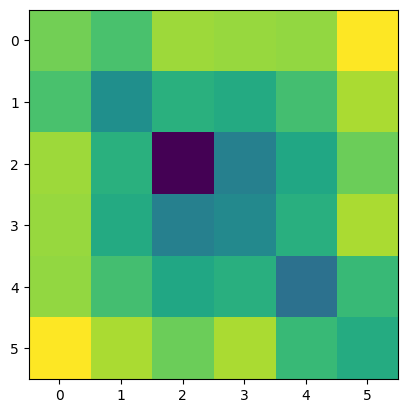

In [3]:
import sys

from src.models.sequence.orca import Orca
orca_model=Orca().to('cuda')
seq_ids =torch.from_numpy(sampled_data[0]).squeeze(0)
seq_ids = seq_ids.float().to('cuda')
target = torch.from_numpy(sampled_data[1]).squeeze(0)
target = target.float().to('cuda')

checkpoint=torch.load(orca_path)

torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "module."
        )

orca_model.load_state_dict(checkpoint,strict=False)

prediction,_=orca_model(seq_ids)

corr=genomic_structure_corr(prediction,target)
print(corr)
mse=genomic_structure_mse(prediction,target)
print(mse)

#plot prediction as image
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(prediction.cpu().detach().numpy()[0])






0.43569863597676173
tensor(0.0184, device='cuda:0')


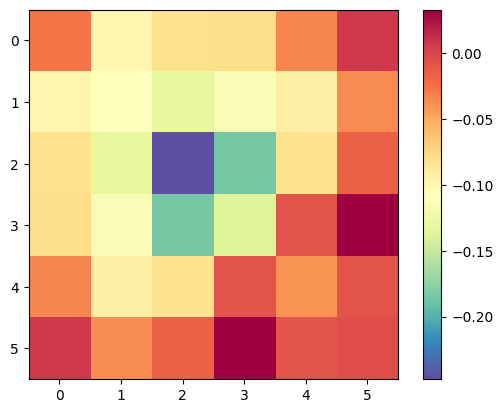

In [4]:
#import autotokenizer
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn

from model.hyena import Hyena

with torch.no_grad():
    hyena_tokenizer=AutoTokenizer.from_pretrained("/weight/hyenadna/hyenadna-large-1m-seqlen",trust_remote_code=True)
    hyena_model=Hyena(pretrained_weight='/weight/hyenadna/hyenadna-large-1m-seqlen',max_length=6000).to('cuda')
    full_sequence=[]
    checkpoint=torch.load(hyena_path)
    # torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    #         checkpoint, "model.backbone."
    #     )
    # torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    #         checkpoint, "decoder.0.length_transform_2."
    #     )

    #edit key name in hyena_decoder
    
    hyena_model.load_state_dict(checkpoint)
    hyena_model.eval()

    sequence_encoded=hyena_tokenizer(sequence,
                        add_special_tokens= False,  # this is what controls adding eos
                        padding="max_length",
                        max_length=max_length*batch_size,
                        truncation=True,
                    )


    sequence_tensor=torch.tensor(sequence_encoded['input_ids']).to('cuda')
    sequence_tensor=torch.reshape(sequence_tensor,(batch_size,max_length))
    mat_hyena=hyena_model(sequence_tensor)

    #calculate the 
    corr=genomic_structure_corr(mat_hyena,target)
    print(corr)
    mse=genomic_structure_mse(mat_hyena,target)
    print(mse)
from matplotlib import pyplot as plt
def figshow(x, np=False):
        if np:
            plt.imshow(x.squeeze())
        else:
            plt.imshow(x.squeeze().cpu().detach().numpy())
        #remove boudary
        plt.axis('off')
        plt.show()
#plot the target and predicted genomic structure
# figure,(axes1, axes2, axes3, axes4, axes5)=plt.subplots(1, 5,figsize=(20,5))
# axes1.imshow(target[0].squeeze().cpu().detach().numpy())
# axes1.axis('off')
# axes1

plt.imshow(mat_hyena[0].cpu().detach().numpy(),cmap = 'Spectral_r')
plt.colorbar()

0.5025163932008324
tensor(0.0168, device='cuda:0')


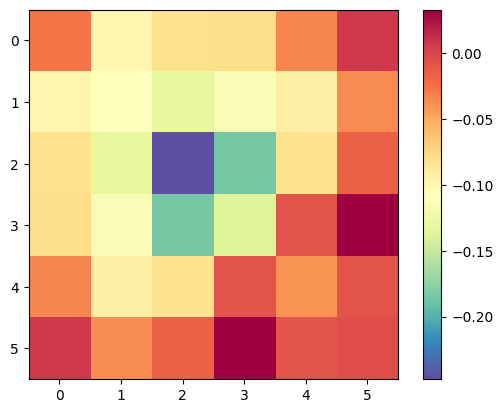

In [5]:
#import autotokenizer
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn
from model.mamba import Mamba

with torch.no_grad():
    Mamba_tokenizer=AutoTokenizer.from_pretrained("/weight/mamba/caduceus-ph_seqlen-131k_d_model-256_n_layer-16",trust_remote_code=True)
    Mamba_model=Mamba(pretrained_weight='/weight/mamba/caduceus-ph_seqlen-131k_d_model-256_n_layer-16',max_length=6000).to('cuda')
    full_sequence=[]
    checkpoint=torch.load(mamba_path)
    # torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    #         checkpoint, "model.backbone."
    #     )
    # torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    #         checkpoint, "decoder.0.length_transform_2."
    #     )

    #edit key name in hyena_decoder
    
    Mamba_model.load_state_dict(checkpoint)
    Mamba_model.eval()

    sequence_encoded=Mamba_tokenizer(sequence,
                        add_special_tokens= False,  # this is what controls adding eos
                        padding="max_length",
                        max_length=max_length*batch_size,
                        truncation=True,
                    )


    sequence_tensor=torch.tensor(sequence_encoded['input_ids']).to('cuda')
    sequence_tensor=torch.reshape(sequence_tensor,(batch_size,max_length))
    mat_mamba=Mamba_model(sequence_tensor)

    #calculate the 
    corr=genomic_structure_corr(mat_mamba,target)
    print(corr)
    mse=genomic_structure_mse(mat_mamba,target)
    print(mse)
from matplotlib import pyplot as plt
def figshow(x, np=False):
        if np:
            plt.imshow(x.squeeze())
        else:
            plt.imshow(x.squeeze().cpu().detach().numpy())
        #remove boudary
        plt.axis('off')
        plt.show()
#plot the target and predicted genomic structure
# figure,(axes1, axes2, axes3, axes4, axes5)=plt.subplots(1, 5,figsize=(20,5))
# axes1.imshow(target[0].squeeze().cpu().detach().numpy())
# axes1.axis('off')
# axes1

plt.imshow(mat_hyena[0].cpu().detach().numpy(),cmap = 'Spectral_r')
plt.colorbar()

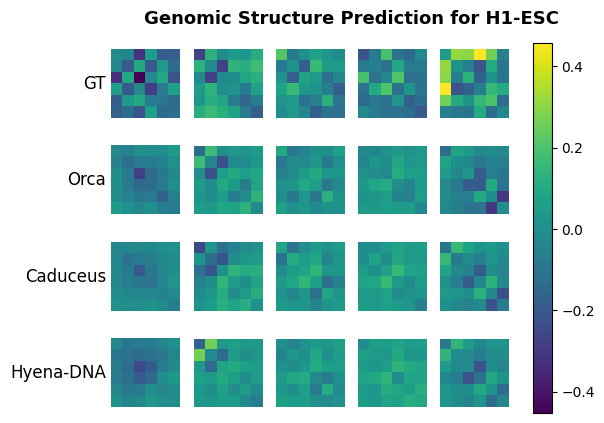

In [6]:
#plot nxn image
rows = ['GT','Orca','Caduceus','Hyena-DNA']
out_collection=[]
normmat_bydist = np.exp(
                np.load("/resources/resources/4DNFI9GMP2J8.rebinned.mcool.expected.res1000.npy")
            )[:6]
normmat = normmat_bydist[np.abs(np.arange(6)[:, None] - np.arange(6)[None, :])]
normmat_r = torch.from_numpy(normmat).float().cuda()
eps = torch.min(normmat_r)
target_r=torch.log(((target + eps) / (normmat_r + eps)))
out_collection.append(target_r.cpu().detach().numpy())
out_collection.append(prediction.cpu().detach().numpy())
out_collection.append(mat_mamba.cpu().detach().numpy())
out_collection.append(mat_hyena.cpu().detach().numpy())
_min, _max = np.amin(out_collection), np.amax(out_collection)
fig,axes = plt.subplots(4,5)
for ax, row in zip(axes[:,0], rows):
    ax2 = ax.twinx()
    ax2.yaxis.set_label_position('left')
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    #set ticks invisible
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticks([])
    ax2.set_ylabel(row, rotation=0, size='large',
                   ha='right', va='center')
for i in range(4):
    for j in range(5):
        ax_n=axes[i,j].imshow(out_collection[i][j], vmin = _min, vmax = _max)
        axes[i,j].axis('off')
        axes[i,j].autoscale(False)
fig.colorbar(ax_n,ax=axes,orientation='vertical')

plt.suptitle('Genomic Structure Prediction for H1-ESC',fontsize=13,y=0.95,fontweight='bold')
plt.show()
        #show value bar
#save plt as pdf
fig.savefig('/assets/genomic_structure_h1esc.pdf',dpi=300,bbox_inches='tight')
fig.savefig('/assets/genomic_structure_h1esc.png',dpi=300,bbox_inches='tight')